# Import Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import missingno as msno

# Import Data

In [2]:
DATA_PREPROCESSED_PATH = '../data/preprocessed/'
DATA_PROCESSED_PATH = '../data/processed/'

In [3]:
train_data = pd.read_csv(DATA_PREPROCESSED_PATH + 'train_data_selected_columns.csv')

In [4]:
train_data.shape

(8523, 11)

In [5]:
train_data.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Data Dictionary

- **Item_Identifier**: nombre o identificador del producto
- **Item_Weight:** peso del producto en gramos
- **Item_Fat_Content**: clasificación del producto en términos de grasas contenidas en él.
- **Item_Visibility**: scoring de visibilidad del producto: medida que hace referencia al conocimiento del producto en el consumidor. ¿Qué tan fácil puede ser encontrado el producto?
- **Item_Type**: tipo de producto
- **Item_MRP**: máximum retailed price. Precio calculado por el fabricante que indica el precio más alto que se puede cobrar por el producto.
- **Outlet_Identifier**: identificador de la tienda
- **Outlet_Establishment_Year**: año de lanzamiento de la tienda
- **Outlet_Size**: tamaño de la tienda
- **Outlet_Location_Type**: clasificación de las tiendas según ubicación
- **Outlet_Type**: tipo de tienda
- **Item_Outlet_Sales**: ventas del producto en cada observacion

## Data Types

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 732.6+ KB


**Categorical variables:**
- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

**Numerical variables:**
- Item_Visibility
- Item_MRP
- Outlet_Establishment_Year (It may be convenient to create a "store_age" column in years).
- Item_Outlet_Sales (Variable to predict)

## Null values management

Let's see the percentage of null rows for each column of the dataset.

In [7]:
train_data.isnull().sum()/train_data.shape[0]*100

Item_Identifier               0.000000
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

We can see that there are one columns that contain null values in a considerable percentage:
- Outlet_Size (28.27%). It is a categorical variable. We can: impute it with mode value, or add a new category called "No Data". Or delete these rows.

**Let's see how the null values are distributed in the dataset, with respect to other variables.**

<Axes: >

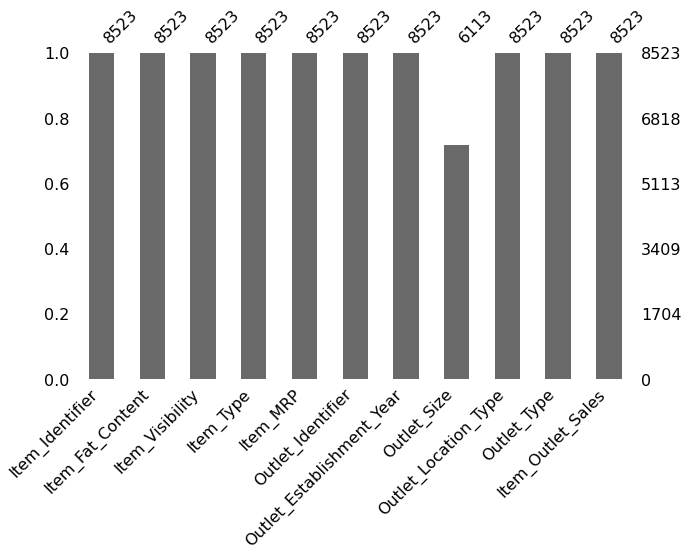

In [8]:
msno.bar(train_data, figsize=(10, 6))

<Axes: >

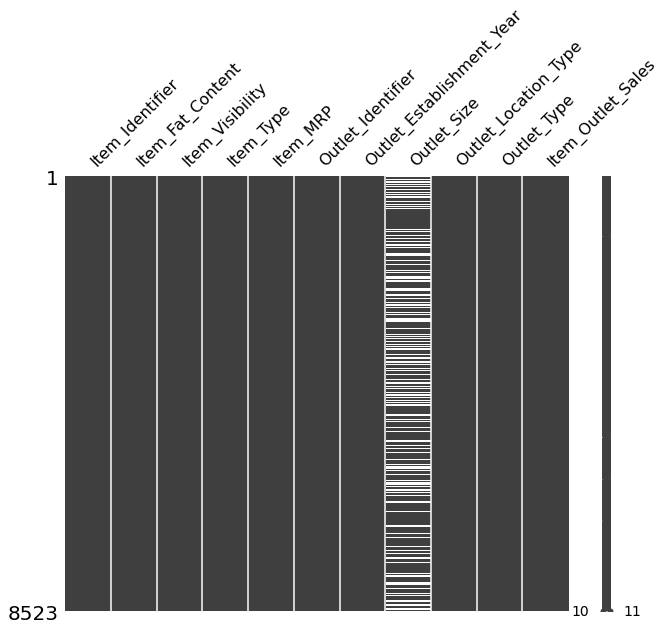

In [9]:
msno.matrix(train_data, figsize=(10, 8))

- We can see that the null values of the variable "Outlet_Size" are random in the dataset (Data is Missing At Random - MAR -)
- In this case, will replace null values using Frequent Categorical Imputation.

**'Outlet_Size' imputation**

In [10]:
train_data_imp = train_data.copy()

In [11]:
imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
train_data_imp["Outlet_Size"]  = imp_most_frequent.fit_transform(train_data_imp["Outlet_Size"].to_numpy().reshape(-1,1))

In [12]:
train_data_imp.isnull().sum()/train_data_imp.shape[0]*100

Item_Identifier              0.0
Item_Fat_Content             0.0
Item_Visibility              0.0
Item_Type                    0.0
Item_MRP                     0.0
Outlet_Identifier            0.0
Outlet_Establishment_Year    0.0
Outlet_Size                  0.0
Outlet_Location_Type         0.0
Outlet_Type                  0.0
Item_Outlet_Sales            0.0
dtype: float64

**Let's check if there were changes in the variable "Outlet_Size" with respect to sales.**

In [13]:
train_data['Outlet_Size'].mode()

0    Medium
Name: Outlet_Size, dtype: object

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

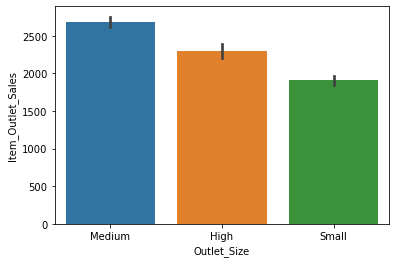

In [14]:
sns.barplot(data=train_data, x="Outlet_Size", y="Item_Outlet_Sales") # Before imputation

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

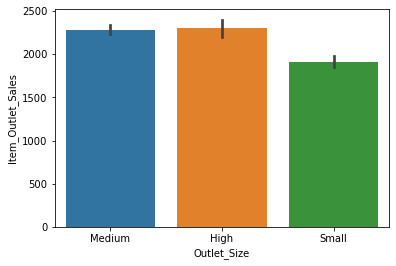

In [15]:
sns.barplot(data=train_data_imp, x="Outlet_Size", y="Item_Outlet_Sales") # After imputation

- Average sales per "Outlet_Size" remained similar (with a minimal increase in the "High" category).

## Outliers Data

We analyzed the existence of extreme values for numerical variables.

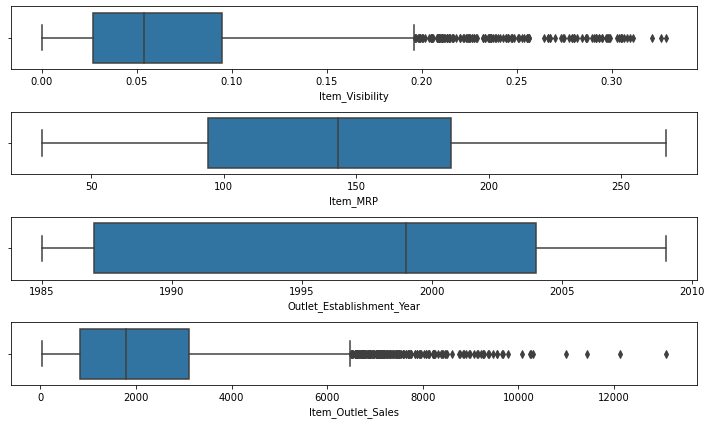

In [16]:
fig, axs = plt.subplots(4, figsize = (10,6))
plt1 = sns.boxplot(x=train_data_imp["Item_Visibility"], ax = axs[0])
plt2 = sns.boxplot(x=train_data_imp["Item_MRP"], ax = axs[1])
plt3 = sns.boxplot(x=train_data_imp["Outlet_Establishment_Year"], ax = axs[2])
plt4 = sns.boxplot(x=train_data_imp["Item_Outlet_Sales"], ax = axs[3])
plt.tight_layout()

In [17]:
train_data_imp[train_data_imp["Item_Visibility"]>0.18].shape[0]/train_data.shape[0]*100

2.675114396339317

In [18]:
train_data_imp[train_data_imp["Item_Outlet_Sales"]>6200].shape[0]/train_data.shape[0]*100

2.792443975126129

We see that we have extreme values, at the upper end of the following variables, and the number of records they represent approximately in percentage are:
- Item_Visibility (2.67% of values greater than 0.18)
- Item_Outlet_Sales (2.79% of values greater than 6000)

As the extreme values represent a very low percentage, we decided to leave them.

Possible improvement: Eliminate outliers with the interquartile range method.

**Lets drop "Item_Identifier" column as it is not going to help us in prediction or in analysis.**

In [19]:
train_data_clean = train_data_imp.copy()

In [20]:
train_data_clean=train_data_clean.drop('Item_Identifier', axis=1)

# También hay que eliminar "Outlet_Identifier"?

## Categorical data transformation

**Categorical variables:**
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

**Convert ordinal categorical to numeric**

In [21]:
train_data_clean['Outlet_Size'].nunique(), train_data_clean['Outlet_Size'].unique() # ordinal

(3, array(['Medium', 'High', 'Small'], dtype=object))

In [22]:
outlet_size_dict = { 
    'Small': 0,
    'Medium': 1,
    'High': 2,
}
train_data_clean['Outlet_Size'].replace(outlet_size_dict, inplace = True)

**Convert nominal categorical to numeric**

In [23]:
train_data_clean['Item_Fat_Content'].nunique(), train_data_clean['Item_Fat_Content'].unique()

(2, array(['Low Fat', 'Regular'], dtype=object))

In [24]:
train_data_clean['Item_Fat_Content'].replace({'Low Fat':0, 'Regular':1}, inplace=True)

In [25]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False), ['Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type']),
    remainder='passthrough')

transformed = transformer.fit_transform(train_data_clean)
train_data_clean = pd.DataFrame(transformed, columns=transformer.get_feature_names_out().tolist())

In [26]:
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 39 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   onehotencoder__Item_Type_Baking Goods           8523 non-null   float64
 1   onehotencoder__Item_Type_Breads                 8523 non-null   float64
 2   onehotencoder__Item_Type_Breakfast              8523 non-null   float64
 3   onehotencoder__Item_Type_Canned                 8523 non-null   float64
 4   onehotencoder__Item_Type_Dairy                  8523 non-null   float64
 5   onehotencoder__Item_Type_Frozen Foods           8523 non-null   float64
 6   onehotencoder__Item_Type_Fruits and Vegetables  8523 non-null   float64
 7   onehotencoder__Item_Type_Hard Drinks            8523 non-null   float64
 8   onehotencoder__Item_Type_Health and Hygiene     8523 non-null   float64
 9   onehotencoder__Item_Type_Household       

In [27]:
train_data_clean.head()

,onehotencoder__Item_Type_Baking Goods,onehotencoder__Item_Type_Breads,onehotencoder__Item_Type_Breakfast,onehotencoder__Item_Type_Canned,onehotencoder__Item_Type_Dairy,onehotencoder__Item_Type_Frozen Foods,onehotencoder__Item_Type_Fruits and Vegetables,onehotencoder__Item_Type_Hard Drinks,onehotencoder__Item_Type_Health and Hygiene,onehotencoder__Item_Type_Household,...,onehotencoder__Outlet_Type_Grocery Store,onehotencoder__Outlet_Type_Supermarket Type1,onehotencoder__Outlet_Type_Supermarket Type2,onehotencoder__Outlet_Type_Supermarket Type3,remainder__Item_Fat_Content,remainder__Item_Visibility,remainder__Item_MRP,remainder__Outlet_Establishment_Year,remainder__Outlet_Size,remainder__Item_Outlet_Sales
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.016047,249.8092,1999.0,1.0,3735.1380
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.019278,48.2692,2009.0,1.0,443.4228
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.016760,141.6180,1999.0,1.0,2097.2700
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.000000,182.0950,1998.0,1.0,732.3800
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.000000,53.8614,1987.0,2.0,994.7052


## Export Dataset with transformed columns

In [28]:
train_data_clean.to_csv(DATA_PROCESSED_PATH + 'train_data_transformed_columns.csv', index=False)